# Recreating the Nile result

In [1]:
import csv
import datetime
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pytest
import sys
%matplotlib inline

sys.path.append('..')

from cp_probability_model import CpModel
from BVAR_NIG import BVARNIG
from detector import Detector
from Evaluation_tool import EvaluationTool

### Read in the data

In [2]:
nile_file = os.path.join(os.getcwd(), "..", "Data", "nile.txt")
raw_data = []
count = 0
with open(nile_file) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        raw_data += row

raw_data_float = []
for entry in raw_data:
    raw_data_float.append(float(entry))
raw_data = raw_data_float


### Put data into format compatible with the Detector class

In [3]:
T = int(len(raw_data) / 2)
S1, S2 = 1, 1
data = np.array(raw_data).reshape(T, 2)
dates = data[:, 0]
river_height = data[:, 1]
mean, variance = np.mean(river_height), np.var(river_height)
river_height = (river_height - mean) / np.sqrt(variance)

"""STEP 3: Get dates"""
all_dates = []
for i in range(622+2, 1285):
    all_dates.append(datetime.date(i, 1,1))


### Set up initial hyperparameters and lag lengths

These values will be updated and optimised as we go along.

In [4]:
intensity = 100
cp_model = CpModel(intensity)
a, b = 1, 1
prior_mean_scale, prior_var_scale = 0, 0.075

### Set up the autoregression models

For a set of initial hyperparameters across a range of lag times, generate the model objects.

In [5]:
upper_AR = 3
lower_AR = 1
AR_models = []

for lag in range(lower_AR, upper_AR + 1):
    """Generate next model object"""
    AR_models += [BVARNIG(
        prior_a=a, prior_b=b,
        S1=S1, S2=S2,
        prior_mean_scale=prior_mean_scale,
        prior_var_scale=prior_var_scale,
        intercept_grouping=None,
        nbh_sequence=[0] * lag,
        restriction_sequence=[0] * lag,
        hyperparameter_optimization="online")]


### Create the model universe 

Put all the model objects together, create model universe and the model priors.


In [6]:
model_universe = np.array(AR_models)
model_prior = np.array([1 / len(model_universe)] * len(model_universe))

### Build and run the detector

In [7]:
detector = Detector(
    data=river_height,
    model_universe=model_universe,
    model_prior=model_prior,
    cp_model=cp_model,
    S1=S1, S2=S2, T=T,
    store_rl=True, store_mrl=True,
    trim_type="keep_K", threshold=50,
    notifications=50,
    save_performance_indicators=True,
    generalized_bayes_rld="kullback_leibler",
    alpha_param_learning="individual",
    alpha_param=0.01,
    alpha_param_opt_t=30,
    alpha_rld_learning=True,
    loss_der_rld_learning="squared_loss",
    loss_param_learning="squared_loss")
detector.run()

Initializing BVAR object
Initializing BVAR object
Initializing BVAR object
Processing observation #50
Last iteration took 0.02185644600000014 seconds
Processing observation #100
Last iteration took 0.02313601899999984 seconds
Processing observation #150
Last iteration took 0.017225827999999943 seconds
Processing observation #200
Last iteration took 0.021389671000000554 seconds
Processing observation #250
Last iteration took 0.019469242999999636 seconds
Processing observation #300
Last iteration took 0.018416655000000226 seconds
Processing observation #350
Last iteration took 0.020114790999999244 seconds
Processing observation #400
Last iteration took 0.06588933599999969 seconds
Processing observation #450
Last iteration took 0.018745616000000354 seconds
Processing observation #500
Last iteration took 0.02035073699999934 seconds
Processing observation #550
Last iteration took 0.02278785900000102 seconds
Processing observation #600
Last iteration took 0.04124334199999957 seconds
Processi

In [8]:
print ('MSE: {:3.3f}'.format(np.mean(detector.MSE)))
print ('NLL: {:3.3f}'.format(np.mean(detector.negative_log_likelihood)))

MSE: 0.548
NLL: 1.117


In [9]:
EvT = EvaluationTool()
EvT.build_EvaluationTool_via_run_detector(detector)

rmax =  660


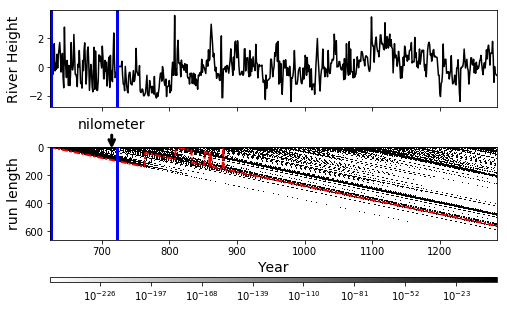

In [10]:
"""get MAP CPs in range"""
segmentation = np.array(EvT.results[EvT.names.index("MAP CPs")][-2])
models = np.union1d([e[1] for e in segmentation],
                    [e[1] for e in segmentation]) 


"""Obtain the plot for RLD"""
start, stop = (2007 + 7/12), 2009
#start, stop = datetime.date(2007, 8, 1), datetime.date(2008, 12, 31)
height_ratio =[10,14]
custom_colors = ["blue", "purple"] #["green", "darkviolet", "orange", "purple", "turquoise"]
fig, ax_array = plt.subplots(2, figsize=(8,5), sharex = True, 
                             gridspec_kw = {'height_ratios':height_ratio})
plt.subplots_adjust(hspace = .35, left = None, bottom = None, right = None, top = None)

"""Get the date format"""
years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')

"""placement of y-labels"""
ylabel_coords = [-0.065, 0.5]

EvT.plot_raw_TS(river_height[2:].reshape(T-2,1), 
                indices = [0], 
                xlab = None, 
                show_MAP_CPs = True, 
                           time_range = np.linspace(1,
                             T-2, 
                             T-2, dtype=int), 
                           print_plt = False,
                       ylab = "River Height", ax = ax_array[0],
                       all_dates = np.linspace(622 + 1, 1284, 1284 - (622 + 1), dtype = int),#None, #all_dates, 
                       custom_colors_series = ["black"],
                       custom_colors_CPs = ["blue", "blue"],
                       custom_linestyles = ["solid"]*2,
                       ylab_fontsize = 14,
                       ylabel_coords = ylabel_coords,
                       set_ylims = (-2.75, 3.95)
                       )

EvT.plot_run_length_distr(
    buffer=0, 
    show_MAP_CPs = True, 
    mark_median = False, 
    mark_max = True, 
    upper_limit = 660, 
    print_colorbar = True, 
    colorbar_location= 'bottom',
    log_format = True, 
    aspect_ratio = 'auto', 
    C1=0,C2=1, 
    time_range = np.linspace(1,
                             T-2, 
                             T-2, dtype=int), 
    start = 622 + 2, stop = 1284, #start=start, stop = stop, 
    all_dates = None, #all_dates,
    event_time_list=[715 ],#datetime.date(715,1,1)], 
    label_list=["nilometer"], space_to_colorbar = 0.52,
    custom_colors = ["blue", "blue"], #["blue"]*len(event_time_list),
    custom_linestyles = ["solid"]*3,
    custom_linewidth = 3,
    arrow_colors= ["black"],
    number_fontsize = 14,
    arrow_length = 135,
    arrow_thickness = 3.0,
    xlab_fontsize =14,
    ylab_fontsize = 14, 
    arrows_setleft_indices = [0],
    arrows_setleft_by = [50],
    zero_distance = 0.0,
    ax = ax_array[1], figure = fig,
    no_transform = True,
    date_instructions_formatter = None, #yearsFmt,
    date_instructions_locator = None,
    ylabel_coords = ylabel_coords,
    xlab = "Year",
    arrow_distance = 25
    )

plt.show()
